# Trabalho Final 
Neste trabalho final você irá pôr em prática todas as etapas exercitadas ao longo da mentoria sobre projetos de aprendizado de máquina em uma tarefa de classificação de NLP: detecção de sarcasmo. Segundo Yaghoobian et al:

“Sarcasm detection is the task of identifying irony containing utterances in sentiment-bearing text. However, the figurative and creative nature of sarcasm poses a great challenge for affective computing systems performing sentiment analysis.”

Detecção de sarcasmo é uma tarefa com muitas aplicações práticas interessantes,  mas também é extremamente desafiadora. Padrões linguísticos e sociais que categorizam o sarcasmo podem não estar contido unicamente no texto ou no uso de palavras específicas, dificultando que algoritmos de aprendizado de máquina aprendam a generalizar. Nesse contexto, foi proposto por Khodak et al o dataset SARC, coletado da plataforma Reddit:


“We introduce the Self-Annotated Reddit Corpus (SARC), a large corpus for sarcasm research and for training and evaluating systems for sarcasm detection. The corpus has 1.3 million sarcastic statements -- 10 times more than any previous dataset -- and many times more instances of non-sarcastic statements, allowing for learning in both balanced and unbalanced label regimes. Each statement is furthermore self-annotated -- sarcasm is labeled by the author, not an independent annotator -- and provided with user, topic, and conversation context.”


Em anexo, encontra-se uma amostra do SARC. Dado esse contexto, você deverá criar e validar um modelo de detecção de sarcasmo utilizando esse dataset. O trabalho deverá conter:


1. Análise exploratória

    a. Mostre exemplos de cada classe.

    b. Crie pelo menos 5 gráficos, contendo um que mostre o balanceamento entre as classes. Sugestões de outros gráficos:    termos mais frequentes em cada classe, distribuição da quantidade de palavras em cada classe.

    c. Discuta seus achados.


2. Aprendizado não-supervisionado

    a. Qualquer técnica pode ser utilizada, clusterização ou redução de dimensionalidade. Pode-se usar parte da análise exploratória ou como auxiliar na classificação.


3. Limpeza e pré-processamento dos dados

    a.Pelo menos 3 técnicas de pré-processamento de texto (que já não sejam utilizadas por padrão na vetorização)

    b.Utilize alguma técnica de balanceamento de dados


4. Engenharia de atributos

    a. Selecione dentre os dados disponíveis quais devem ser utilizados como atributos de entrada e o método para representação vetorial.

    b. Utilize pelo menos dois conjuntos de atributos de entrada, comparando as performances. Justifique suas escolhas.


5. Estabelecimento de um baseline

    a.Utilize um modelo simples, não faça otimização de hiperparâmetros. Justifique sua escolha.


6. Seleção e avaliação de modelos

    a. Escolha uma ou mais métricas de desempenho apropriadas para esta tarefa.

    b. Utilize pelo menos 4 algoritmos, realizando a otimização de hiperparâmetros. Destes modelos, ao menos um deve ser um algoritmos deve ser um que não foi visto durante a mentoria. Estude o funcionamento dele. Sugestão: modelo de Deep Learning.

    c. Avalie os algoritmos com hiperparâmetros otimizados no conjunto de teste.


7. Análise de resultados

    a. Mostre exemplos dos erros (falso positivos e falso negativos) para o melhor dos algoritmos experimentados.

    b. Discuta os resultados e aponte quais seriam possíveis melhorias


8. (OPCIONAL) Interpretabilidade

    a. Utilize algum método que permita uma interpretação das predições de algum dos seus modelos.


9. (OPCIONAL) Deploy

    a. Implemente uma API para que o seu melhor modelo possa ser utilizado via requisições HTTP.

## Importando Bibliotecas
Importando bibliotecas que serão utilizadas durante a construção do projeto

In [175]:
# Importando bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
import string
import re
import nltk

from nltk.stem import WordNetLemmatizer

## Fazendo a Leitura da Base de Dados

In [176]:
# Fazendo a leitura do dataset
df_sarc = pd.read_csv('sarc_sample.csv')
df_sarc

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,1,"Of course, just like 3.2 was the true Messiah.",ReticentHedgehog,ffxiv,1,1,0,2016-05,2016-05-02 20:20:37,Is patch 3.3 going to be our savior? Without t...
1,1,Yeah because Iran was 100% muslim prior to 197...,methmobile,worldnews,-3,-1,-1,2016-12,2016-12-30 10:21:31,I suggest you research Iran pre-1979 as well a...
2,1,WELL YOU'RE JUST A BITCH...YOU HAVE TO GO AND ...,dillydelly,nba,1,1,0,2014-05,2014-05-04 08:02:30,Warriors / Clips game threads literally add ze...
3,1,"Yeah, it's dumb to run background checks on po...",Krenolds,AskReddit,1,1,0,2014-09,2014-09-02 08:09:10,"Oh i forgot.., you get to be finger printed wh..."
4,1,"Oh, it's not that bad once you get a handle on...",ericanderton,AskReddit,4,4,0,2011-08,2011-08-24 13:17:20,Haha oh. Definitely not an option than.
...,...,...,...,...,...,...,...,...,...,...
59995,0,"room you mean like, dimension?",Tikikala,digimon,1,1,0,2016-03,2016-03-26 03:42:22,So as another guy pointed out. Huckmon might b...
59996,0,I wasn't too fond of grabner in 14 so I put Be...,mrhairybolo,hockey,1,1,0,2014-08,2014-08-10 05:57:31,Hall - Duchene - Grabner?
59997,0,he wasn't even at worlds in season 4!,Highstalker,leagueoflegends,-1,-1,0,2016-09,2016-09-19 14:41:23,Yeah he was.
59998,0,"Right, but the Trump sign...",gcbeehler5,pics,2,2,0,2016-09,2016-09-01 02:14:54,I wouldn't say you have to be liberal to appre...


## Iniciando Análise Exploratória 
Inicialmente é aplicado um '.describe()' para se ter informações sobre o dataframe no geral, como por exemplo, a quantidade de elementos e etc.

Após, utiliza-se o método '.info()' para ter informações sobre as colunas, como por exemplo, quais são seus tipos e se existem valores nulos.

Associado, a isso, apresenta-se a quantidade de elementos para cada classe do dataframe através do .'value_counts()' trazendo essa visualização se há desbalanceamento entre as classes. Essa análise de desbalanceamento será exposta logo mais através de um gráfico.


In [177]:
round(df_sarc.describe(),2)

,label,score,ups,downs
count,60000.00,60000.00,60000.00,60000.00
mean,0.67,6.85,5.58,-0.14
std,0.47,42.68,39.41,0.35
min,0.00,-143.00,-143.00,-1.00
25%,0.00,1.00,0.00,0.00
50%,1.00,2.00,1.00,0.00
75%,1.00,5.00,4.00,0.00
max,1.00,3325.00,3325.00,0.00


In [178]:
df_sarc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   label           60000 non-null  int64 
 1   comment         59999 non-null  object
 2   author          60000 non-null  object
 3   subreddit       60000 non-null  object
 4   score           60000 non-null  int64 
 5   ups             60000 non-null  int64 
 6   downs           60000 non-null  int64 
 7   date            60000 non-null  object
 8   created_utc     60000 non-null  object
 9   parent_comment  60000 non-null  object
dtypes: int64(4), object(6)
memory usage: 4.6+ MB


In [179]:
df_sarc['label'].value_counts()

1    40000
0    20000
Name: label, dtype: int64

### Exemplo da classe 0 (Sem Sarcasmo)
Continuando a análise, uma amostra dos textos dos comentários sem sarcasmos são apresentados de forma completa, abaixo:

In [180]:
nao_sarc = df_sarc.loc[df_sarc['label'] == 0]
#Utiliza-se o método set_option('max_colwidth', None) que possibilita a apresentação de todo os conteúdos das colunas do datraframe
pd.set_option('max_colwidth', None)
nao_sarc.head(5)

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
40000,0,Then why fire the coach and hire Rich Rod if you guys were already good?,punkinale,CFB,11,11,0,2014-12,2014-12-02 21:00:31,I don't really think that's full circle. Michigan was good before Rich Rod took over
40001,0,"Whoa, easy there Duterte.",buckingbronco1,news,2,-1,-1,2016-12,2016-12-28 21:30:36,"He did. It's a smoking gun to me. I don't give a fucking shit what a court thinks, I don't play by their rules. When you get put in charge of watching over someone so drunk people are worried they're going to die, and you offered to do this, solely so you could be alone with them and then put your dick in them, to me, you're a fucking rapist. And that's what I think he did and that's why he apologized - because he knew he had something to apologize for. I don't care what the statue of Indiana says on rape, I don't care what the school says, I care about what I think rape is and this definitely qualifies. He's the type of loser that can't get pussy, and has to steal it from drunk girls after he manipulates himself into being alone with them."
40002,0,"The same reason Trudeau circlejerks, and Harper hate fests are allowed.",AngryMulcair,canada,3,3,0,2014-11,2014-11-14 23:10:39,Why are stupid and satire articles allowed on this subreddit?
40003,0,Good point but he'll still have to clean it to rack it for the front squat.,arabicfarmer27,Fitness,1,-1,-1,2016-11,2016-11-04 09:34:05,"But it would be a relatively light weight front-squat, he might want some additional squat work on top of that."
40004,0,Damn if I worked for valve my personal ban list would be so long full of kids like these.,MaxStavro,GlobalOffensive,72,72,0,2015-07,2015-07-10 06:39:02,Please don't be this guy.


### Exemplo da classe 1 (Com Sarcasmo)
Continuando a análise, uma amostra dos textos dos comentários com sarcasmos são apresentados de forma completa, abaixo:

In [181]:
sarc = df_sarc.loc[df_sarc['label'] == 1]
#Utiliza-se o método set_option('max_colwidth', None) que possibilita a apresentação de todo os conteúdos das colunas do datraframe
pd.set_option('max_colwidth', None)
sarc.head(5)

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,1,"Of course, just like 3.2 was the true Messiah.",ReticentHedgehog,ffxiv,1,1,0,2016-05,2016-05-02 20:20:37,"Is patch 3.3 going to be our savior? Without trying to sound like a broken record and repeating the many point of views of the growing apocalyptic threads on this forum. I was hoping to get the opinions of everyone if they believe patch 3.3 is going to bring back some of the players who have quit in the last patch or two, or does this feel like another cookie cutter patch that wont stop exit of quality population specifically on the North American servers. I ask this in concern that I have made a assertive effort as of late to refill our FC, and one of the strong points of the patch info so far is that they are installing a cross realm raid tool, which seems like it would diminish the need to recruit for a FC. I personally enjoy the aspect of a 10-15 member FC which can grow close and share things in common to the game and outside the game. But with the game seemingly losing subs it has become harder to find people to come together like I had just described and I don't want to put false hope in those who I have recruited so far. Give me some hope!"
1,1,"Yeah because Iran was 100% muslim prior to 1979, and still is now.",methmobile,worldnews,-3,-1,-1,2016-12,2016-12-30 10:21:31,I suggest you research Iran pre-1979 as well as al-Qatb and the rise of Wahhabism. You are fully entitled to have an opinion and express it (and you do bring up a good point re: rural cobservatism) but you are misinformed.
2,1,WELL YOU'RE JUST A BITCH...YOU HAVE TO GO AND POST AND TAKE YOUR DOWNVOTES,dillydelly,nba,1,1,0,2014-05,2014-05-04 08:02:30,"Warriors / Clips game threads literally add zero value to the game experience. Why would I want to see the words flop, flopped and flopper repeated constantly? Thunder / Clips game threads were pretty good during the season. We'll see how the playoff ones are."
3,1,"Yeah, it's dumb to run background checks on potential teachers.",Krenolds,AskReddit,1,1,0,2014-09,2014-09-02 08:09:10,"Oh i forgot.., you get to be finger printed when you are hired! Awesome!"
4,1,"Oh, it's not that bad once you get a handle on the crippling depression and constant tooth grinding.",ericanderton,AskReddit,4,4,0,2011-08,2011-08-24 13:17:20,Haha oh. Definitely not an option than.


### Gráfico 1 -- Gráfico de Barras
Como já foi falado acima, neste gráfico de barras são apresentados as quantidades de elementos para cada uma das classes. 

Pode-se analisar, que o gráfico demonstra um desbalanceamento entre as classes, sendo que há 40000 linhas de comentários com sarcasmo (classe 1) e somente 20000 linhas de comentários sem sarcasmos (classe 0).

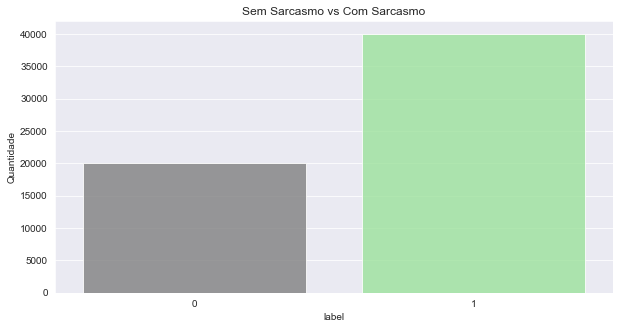

In [182]:
warnings.filterwarnings("ignore")

sns.set_style('darkgrid')
plt.figure(figsize = (10,5))
sns.countplot(df_sarc['label'], alpha =.80, palette= ['grey','lightgreen'])
plt.title('Sem Sarcasmo vs Com Sarcasmo')
plt.ylabel('Quantidade')
plt.show()

## Etapa de Limpeza e Pré-Processamento dos Dados
A etapa de pré-processamento dos dados se faz necessária para a continuidade da análise exploratória dos dados, isso pelo fato de a análise continuar com passos como o de apresentação de termos mais frequentes entre as classes. Logo, este pré-processamento é necessário.

Serão aplicadas algumas etapas de pré-processamento na coluna 'comment'(posteriormente também serão aplicadas na coluna 'parent_comment'), sendo essas:

    - Remoção de Pontuações(Função: remocao_pontuacao): Serão retiradas todas as pontuações dos textos dos comentários,sendo que esses, nesta situação, não trazem informações relevantes.
    - Letras minúsculas (Função: lowering): Retirando todas as palavras em minúscula para manter um padrão.
    - Stop Words (Função: remocao_stop_words): Stopwords são as palavras em qualquer idioma que não adicionam muito significado a uma frase. Eles podem ser ignorados com segurança sem sacrificar o significado da frase. Para alguns mecanismos de pesquisa, essas são algumas das palavras de função curtas mais comuns, como the, is, at, which e on, ou seja, podem ser retiradas
    - Remoção de Números (Função: remocao_numeros): Retirando todos os números que nesta situação, não trazem informações relevantes para a análise exploratória da coluna de comentários, sendo que o foco são as palavras dos textos.
    - Função 'preprocessamento': Na função final 'preprocessamento', são chamadas e aplicadas todas as etapas citadas acima.

##### Nova Coluna: 'clean_comment'
Após todas as estapas de pré-processamento, foi criada uma nova coluna com todos os comentários e seus textos pré-processados.

In [183]:
def remocao_pontuacao(texto):
    nao_pontuado = "".join([i for i in texto if i not in string.punctuation])
    return nao_pontuado

In [184]:
def lowering(texto):
    return texto.lower()

In [185]:
def remocao_numeros(texto):
    number_regex = '\d+'
    x = re.sub(number_regex, '', texto)
    return x

In [186]:
def remocao_stopwords(texto):
    stopwords = nltk.corpus.stopwords.words('english')
    texto_stopwords = [j for j in texto.split() if j not in stopwords]
    frase = " ".join(texto_stopwords)
    return frase 

In [187]:
def preprocessamento(texto):
        texto = remocao_numeros(texto)
        texto = lowering(texto)
        texto = remocao_stopwords(texto)
        texto = remocao_pontuacao(texto)
        return texto
    
pd.reset_option("display.max_colwidth")

df_sarc['comment'] = df_sarc['comment'].astype(str)
# Criei uma nova coluna após o pré-processamento 
df_sarc['clean_comment']= df_sarc['comment'].apply(lambda x: preprocessamento(x))
df_sarc

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment,clean_comment
0,1,"Of course, just like 3.2 was the true Messiah.",ReticentHedgehog,ffxiv,1,1,0,2016-05,2016-05-02 20:20:37,Is patch 3.3 going to be our savior? Without t...,course like true messiah
1,1,Yeah because Iran was 100% muslim prior to 197...,methmobile,worldnews,-3,-1,-1,2016-12,2016-12-30 10:21:31,I suggest you research Iran pre-1979 as well a...,yeah iran muslim prior still now
2,1,WELL YOU'RE JUST A BITCH...YOU HAVE TO GO AND ...,dillydelly,nba,1,1,0,2014-05,2014-05-04 08:02:30,Warriors / Clips game threads literally add ze...,well bitchyou go post take downvotes
3,1,"Yeah, it's dumb to run background checks on po...",Krenolds,AskReddit,1,1,0,2014-09,2014-09-02 08:09:10,"Oh i forgot.., you get to be finger printed wh...",yeah dumb run background checks potential teac...
4,1,"Oh, it's not that bad once you get a handle on...",ericanderton,AskReddit,4,4,0,2011-08,2011-08-24 13:17:20,Haha oh. Definitely not an option than.,oh bad get handle crippling depression constan...
...,...,...,...,...,...,...,...,...,...,...,...
59995,0,"room you mean like, dimension?",Tikikala,digimon,1,1,0,2016-03,2016-03-26 03:42:22,So as another guy pointed out. Huckmon might b...,room mean like dimension
59996,0,I wasn't too fond of grabner in 14 so I put Be...,mrhairybolo,hockey,1,1,0,2014-08,2014-08-10 05:57:31,Hall - Duchene - Grabner?,fond grabner put bergeron middle win draws set...
59997,0,he wasn't even at worlds in season 4!,Highstalker,leagueoflegends,-1,-1,0,2016-09,2016-09-19 14:41:23,Yeah he was.,even worlds season
59998,0,"Right, but the Trump sign...",gcbeehler5,pics,2,2,0,2016-09,2016-09-01 02:14:54,I wouldn't say you have to be liberal to appre...,right trump sign


### Gráficos 2 e 3 - Gráficos de Barras
CONTINUAR DAQUI

Apresentando os termos mais frequentes em cada classe. 

Isso só foi possível após o pré-processamento dos textos, para que por exemplo, pontuações, não fossem escolhidos como termos mais frequentes

In [188]:
# sarc para classe 1 e nao_sarc para a classe 0
sarc = df_sarc.loc[df_sarc['label'] == 1]
nao_sarc = df_sarc.loc[df_sarc['label'] == 0]

#### Gráfico de Termos Mais Frequentes da Classe 0 (Sem Sarcasmo)

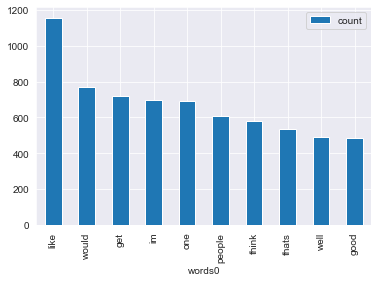

In [189]:
words0 = []

#Pegando termo por termo -- classe 0
for i in nao_sarc['clean_comment']:
    for j in i.split():
        words0.append(j)
        
dfp0 = pd.DataFrame (words0, columns = ['words0'])
dfc = dfp0.groupby('words0').words0.count() \
                               .reset_index(name='count') \
                               .sort_values(['count'], ascending=False) \
                               .head(10).reset_index(drop=True)

dfc.plot.bar(x='words0');

#### Gráfico de Termos Mais Frequentes da Classe 1 (Com Sarcasmo)


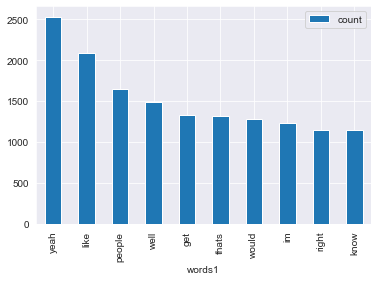

In [190]:
words1 = []

#Pegando termo por termo -- classe 1
for i in sarc['clean_comment']:
    for j in i.split():
        words1.append(j)

dfp1 = pd.DataFrame(words1, columns = ['words1'])
dfc = dfp1.groupby('words1').words1.count() \
                               .reset_index(name='count') \
                               .sort_values(['count'], ascending=False) \
                               .head(10).reset_index(drop=True)

dfc.plot.bar(x='words1');

### Gráfico 4 e 5 -- Distribuição (Histograma e KDE)
#### Finalizando a Análise Exploratória 

Histograma:

KDE:

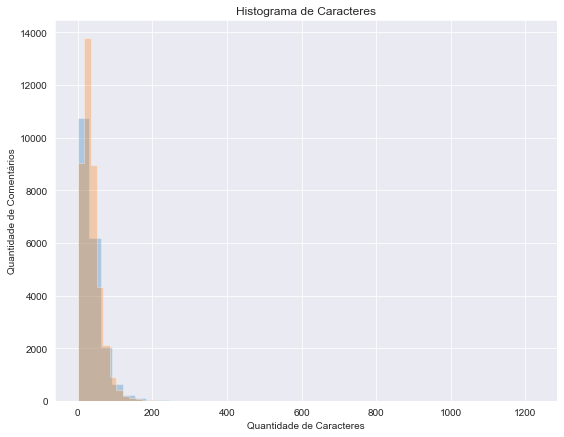

In [191]:
df_sarc['tamanho_texto'] = df_sarc['clean_comment'].apply(len)

x0 = list(df_sarc[df_sarc['label']==0]['tamanho_texto'])
x1 = list(df_sarc[df_sarc['label']==1]['tamanho_texto'])

kwargs = dict(histtype='stepfilled',alpha=0.3, bins=40)
plt.figure(figsize=(9,7))
plt.hist(x0, **kwargs);
plt.hist(x1, **kwargs);
plt.xlabel('Quantidade de Caracteres');
plt.ylabel('Quantidade de Comentários');
plt.title('Histograma de Caracteres');


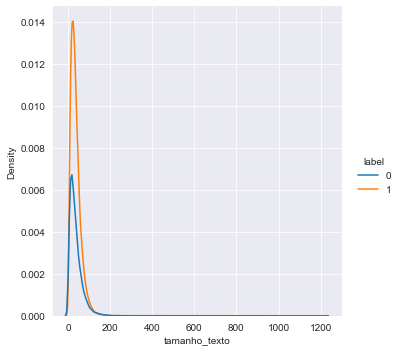

In [192]:
sns.displot(df_sarc, x="tamanho_texto", hue="label", kind="kde");

## Etapa de Limpeza e Pré-Processamento dos Dados -- Continuação
Aqui dará continuidade, o pré-processamento da coluna 'comment' e pré-processarei também a coluna 'parent_comment' para utilização futura, criando uma nova coluna pré-processada 'clean_parent_comment'.

A continuação do pré-processamento ocorre após a análise exploratória pelo fato da continuidade ser importante para o resto do projeto e não para a etapa de análise exploratória.

Serão aplicadas mais algumas etapas de pré-processamento na coluna 'comment'(lematização) e todas as etapas na coluna 'parent_comment', sendo essas:

    - Função 'preprocessamento': Na função final 'preprocessamento', são chamadas e aplicadas todas as etapas citadas acima.
    - Lematização (Função: 'lemmatizacao'): Ela deriva a palavra, mas garante que ela não perca seu significado. A lematização possui um dicionário pré-definido que armazena o contexto das palavras e verifica a palavra no dicionário enquanto diminui.

In [193]:
wordnet_lemmatizer = WordNetLemmatizer()
def lemmatizacao(texto):
    lemm_texto = [wordnet_lemmatizer.lemmatize(word) for word in texto.split()]
    frase = " ".join(lemm_texto)
    return frase

In [194]:
# Fiz essa função preprocessamento2 porque estou trabalhando em mais uma etapa de pré-processamento além da lematização.
def preprocessamento2(texto):
        texto = preprocessamento(texto)
        texto = lemmatizacao(texto)
        return texto
df_sarc['clean_comment']= df_sarc['clean_comment'].apply(lambda x: preprocessamento2(x))
df_sarc['clean_parent_comment']= df_sarc['clean_parent_comment'].apply(lambda x: preprocessamento2(x))